In [1]:
from preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from rank_swapping import rank_swapping
from smote import SMOTE
import numpy as np
from aggregate_features import aggregate_features
from sklearn.tree import DecisionTreeClassifier

In [2]:
from models import models

In [3]:
data = "./data/data_for_student_case.csv"
df = pd.read_csv(data)

# I. Data Pre-Processing

## Re-Label

Column `simple_journal` has the payment status.

`relabel()`:
- drops rows which have `simple_journal` = "Refused", since we are not sure whether it was fraud.
- replaces `simple_journal` = "Chargeback" with `1`, i.e. fraud.
- replaces `simple_journal` = "Settled" with `0`, i.e. not fraud.

In [4]:
df = relabel(df)

non_fraud_count = df[df["simple_journal"] == 0].shape[0]
fraud_count = df[df["simple_journal"] == 1].shape[0]
print(f"Class Distribution: label 1 = {fraud_count/df.shape[0]}, label 0 = {non_fraud_count/df.shape[0]}")

Class Distribution: label 1 = 0.00145547511770364, label 0 = 0.9985445248822964


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Check for NaNs

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237036 entries, 0 to 290381
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   txid                          237036 non-null  int64  
 1   bookingdate                   237036 non-null  object 
 2   issuercountrycode             237032 non-null  object 
 3   txvariantcode                 237036 non-null  object 
 4   bin                           237036 non-null  float64
 5   amount                        237036 non-null  float64
 6   currencycode                  237036 non-null  object 
 7   shoppercountrycode            236694 non-null  object 
 8   shopperinteraction            237036 non-null  object 
 9   simple_journal                237036 non-null  int32  
 10  cardverificationcodesupplied  223842 non-null  object 
 11  cvcresponsecode               237036 non-null  int64  
 12  creationdate                  237036 non-nul

## Remove NaNs from `issuercountrycode`, `shoppercountrycode` and `cardverificationcodesupplied`

We replace NaN with `False` for `cardverificationcodesupplied` since we assume missing value means card verification code was not supplied.

Rest are replaced with dummy values which we numerically encode below

In [6]:
df = replace_na_with(df, "cardverificationcodesupplied", False)
df = replace_na_with(df, "issuercountrycode", "ZZ")
df = replace_na_with(df, "shoppercountrycode", "ZZ")

## Remove NaN in `mail_id`

The NaNs in `mail_id` column are strings "na", which we replace with dummy value "email99999" and later encode it numerically

In [7]:
df.loc[df["mail_id"].str.contains("na", case=False), "mail_id"] = "email99999"

## Convert `creationdate` and `bookingdate` to a pandas datetime object

This allows more flexibility later for date wise aggregation using datetime functions

In [8]:
df["creationdate"] = pd.to_datetime(df["creationdate"])
df["date"] = df["creationdate"].dt.date

df["bookingdate"] = pd.to_datetime(df["bookingdate"])

## Encode `issuecountrycode` and `shoppercountrycode`

- First we create a country code list that encapsulates both shopper and issue country codes
- Then we encode `issuecountrycode` and `shoppercountrycode` using this full list

In [9]:
unique_issuer_cc = df["issuercountrycode"].unique().tolist()
unique_shopper_cc = df["shoppercountrycode"].unique().tolist()
unique_codes = list(set(unique_issuer_cc + unique_shopper_cc))
df, issuer_country_enc = encode(df, "issuercountrycode", values=unique_codes)
df, shopper_country_enc = encode(df, "shoppercountrycode", values=unique_codes)

## Convert transaction amount in `amount` to EUR

- The transaction amount in the `amount` column is in the currency according to the `currencycode` column
- We convert all transaction amounts to euros using a fixed exchange rate

In [10]:
df["amount_eur"] = df.apply(lambda x: conv_to_eur(x), axis=1)

## Replace `accountcode` with the respective Country Code

In [11]:
df["accountcode"] = df["accountcode"].apply(lambda x: re.sub("Account", "", x))
df["accountcode_cc"] = 0
df.loc[(df["accountcode"] == "UK"), "accountcode_cc"] = "GB"
df.loc[(df["accountcode"] == "Mexico"), "accountcode_cc"] = "MX"
df.loc[(df["accountcode"] == "Sweden"), "accountcode_cc"] = "SE"
df.loc[(df["accountcode"] == "APAC"), "accountcode_cc"] = "APAC"
df.drop(["accountcode"], axis=1, inplace=True)

## Replace all `cvcresponsecode` values above 2 with a single value

`cvcresponsecode` 3 - 6 correspond to not checked

In [12]:
df.loc[df["cvcresponsecode"] > 2, "cvcresponsecode"] = 3

## Numerical Encoding of categorical columns

We can replace the categorical columns with positive integers, since we need numbers to input to the ML Model

In [13]:
df, card_enc = encode(df, "card_id")
df, ip_enc = encode(df, "ip_id")
df, tx_var_enc = encode(df, "txvariantcode")
df, shop_enc = encode(df, "shopperinteraction")
df, card_verif_enc = encode(df, "cardverificationcodesupplied")
df, email_enc = encode(df, "mail_id")
df, currency_enc = encode(df, "currencycode")
df, account_cc_enc = encode(df, "accountcode_cc")

---
---

# II. Visualization

## Distribution of the Transaction Amount

- We analyse the distribution of `amount_eur` column for fraud and non-fraud cases
- We hope to find a significant difference between them which will allow us to classify the cases well
- To do this, we make a boxplot to see the quartiles and outliers

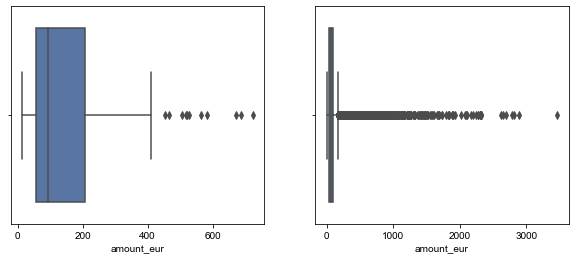

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))

sns.set(style="whitegrid")
sns.boxplot(x="amount_eur", data=df[df.simple_journal == 1], ax=ax1)

sns.boxplot(x="amount_eur", data=df[df.simple_journal == 0], ax=ax2)
plt.show()

We can see here that there are outlier values for the non-fraud case. For further analysis, we remove the records where an amount > 180 is spent in a non-fraudulent transaction.

In [15]:
df = df[(df["amount_eur"] <= 150)|(df["simple_journal"] == 1)]

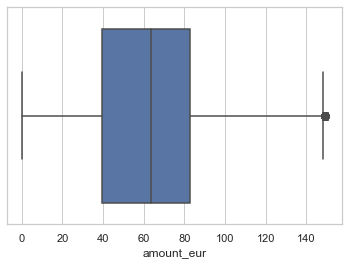

In [16]:
sns.set(style="whitegrid")
sns.boxplot(x="amount_eur", data=df[df.simple_journal == 0])

Now, if we compare this to the distribution of transaction amount in the fraudulent cases, there is a significant difference in distribution

---

## Heatmap

Put explanation here

Text(0.5, 1.0, 'Normal')

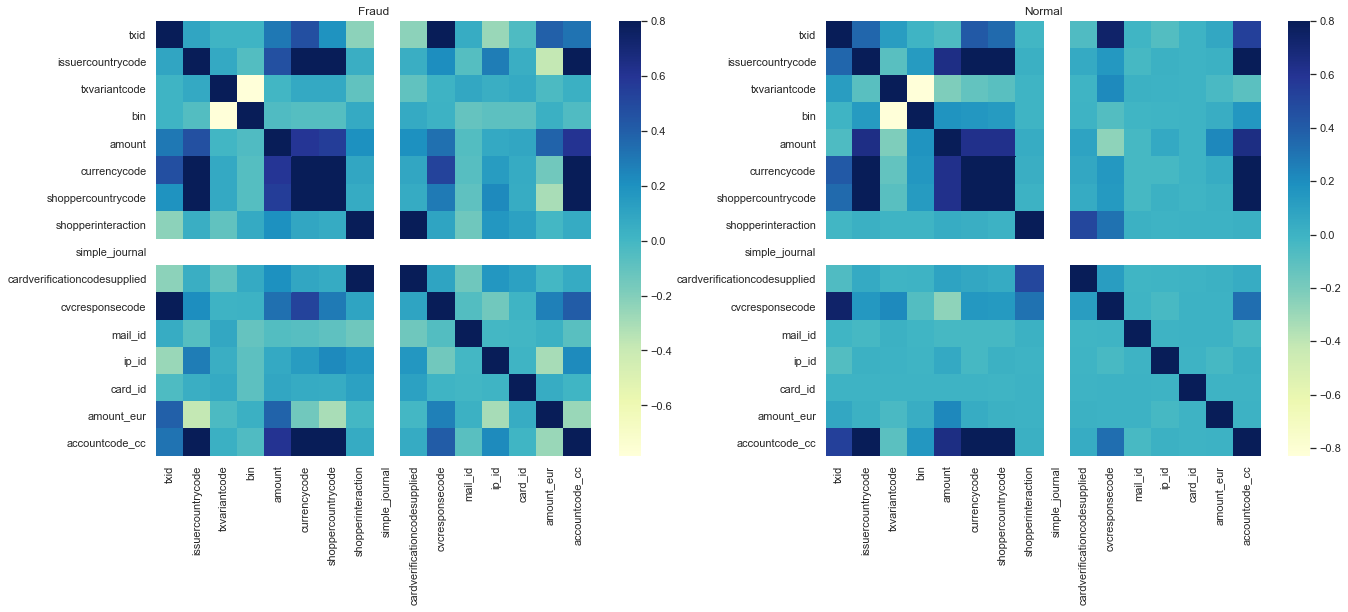

In [18]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df.query('simple_journal==1').corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df.query('simple_journal==0').corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

# plt.show()

---

## Absolute Difference in Correlation
Put Explanation here

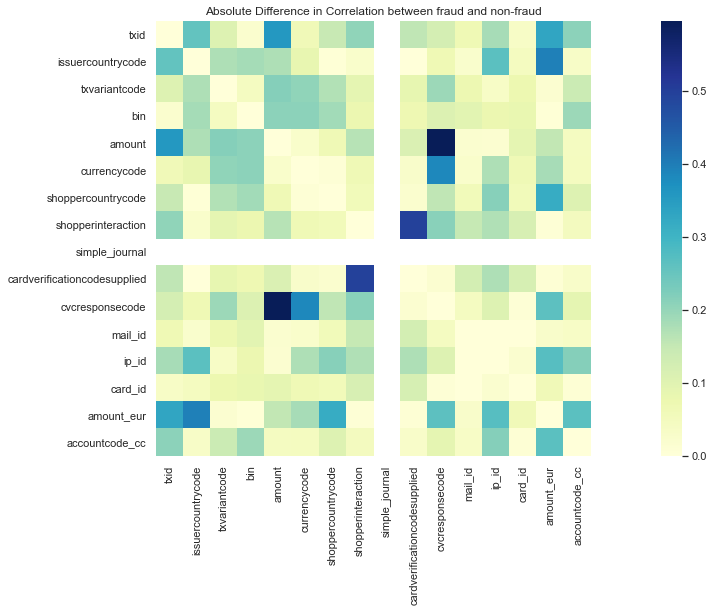

In [19]:
f, (ax1) = plt.subplots(1,figsize =(25, 8))
abs_diff_in_corr = np.abs(df.query('simple_journal==0').corr() - df.query('simple_journal==1').corr())
# print(abs_diff_in_corr)
sns.heatmap(abs_diff_in_corr, square=True, cmap = 'YlGnBu')
ax1.set_title('Absolute Difference in Correlation between fraud and non-fraud')
plt.show()

---

## Visualize currencycode

Are transactions made in some currencies pre-disposed to having more fraudulent transactions?

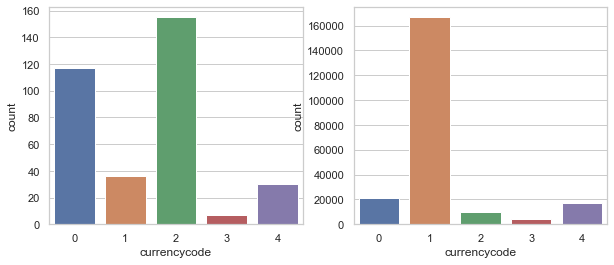

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))

sns.countplot(data=df[df.simple_journal == 1], x="currencycode", ax=ax1)

sns.countplot(data=df[df.simple_journal == 0], x="currencycode", ax=ax2)
plt.show()

## Visualize Card Type

Are transactions made using some credit card types pre-disposed to having more fraudulent transactions?

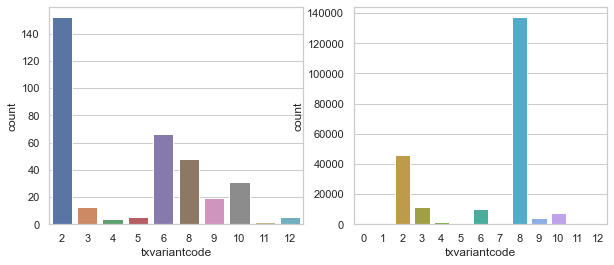

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))

sns.countplot(data=df[df.simple_journal == 1], x="txvariantcode", ax=ax1)

sns.countplot(data=df[df.simple_journal == 0], x="txvariantcode", ax=ax2)
plt.show()

## Visualization of Transaction Types

TODO: add explanation

0: Subscription
1: Ecommerce
2: POS transaction

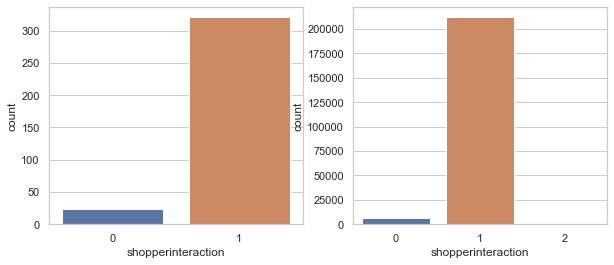

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))

sns.countplot(data=df[df.simple_journal == 1], x="shopperinteraction", ax=ax1)

sns.countplot(data=df[df.simple_journal == 0], x="shopperinteraction", ax=ax2)
plt.show()

There does not seem to be any interesting insight apart from the fact that no fraud happens in case of POS transactions

---

## Visualize frauds per email id

- We hypothesize that transactions with no email ids may have more fraud
- So we see the number frauds per email id

no email id provided (email99999) corresponds to mail_id=208731

In [23]:
email_enc.transform(["email99999"])

array([208731])

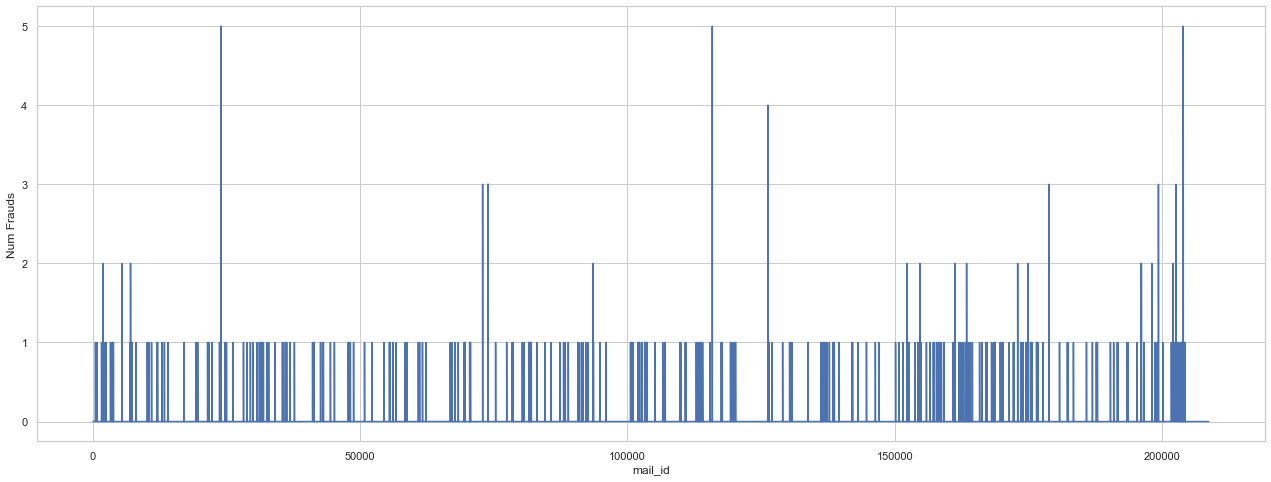

In [19]:
mail_id_df = df[['mail_id','simple_journal']].groupby(['mail_id']).sum()
mail_id_df = mail_id_df.sort_index()
f, (ax) = plt.subplots(1,figsize =(22, 8))
sns.lineplot(x=mail_id_df.index,y=mail_id_df['simple_journal'])
ax.set(ylabel = "Num Frauds")
plt.show()

In [ ]:
mail_id_df.sort_index().loc[208731]

Here, we see that there are very few email ids which even have multiple fraud transactions. Also, as seen above when no email is provided, there are 0 fraudulent transactions.

---

# Visualize Card Issuer

Do some transaction made using cards from certain card issuers entail more fraud?

In [ ]:
bin_df = df[['bin','simple_journal']].groupby(['bin']).sum()
bin_df = bin_df.sort_index()
f, (ax) = plt.subplots(1,figsize =(22, 8))
sns.lineplot(x=bin_df.index,y=bin_df['simple_journal'])
ax.set(ylabel = "Num Frauds")
plt.show()

We can see that some card issuers do have a tendency to accrue higher fraudulent transactions from their cards

---

## CVCResponseCode

Write description here

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))
sns.countplot(x="cvcresponsecode", data=df[df.simple_journal == 1], ax=ax1)
ax1.set_title('cvcresponse code histogram for fraud cases')

sns.countplot(x="cvcresponsecode", data=df[df.simple_journal == 0], ax=ax2)
ax2.set_title('cvcresponse code histogram for non fraud cases')

We can see that the cvcresponsecode 0 is more prominent in cases of fraud

---

## Isomap

Put explanation here

TODO: Does not run on 8GB RAM. Need to fix this

In [ ]:
fraud_index = np.where(df['simple_journal'] == 1)[0]

not_fraud_index = np.where(df['simple_journal'] == 0)[0]
not_fraud_index = np.random.choice(not_fraud_index, size= int (0.01*len(not_fraud_index)), replace=False)
columns = ['issuercountrycode','txvariantcode','bin','amount','currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','mail_id','accountcode_cc','ip_id','card_id','amount_eur']
X = df[columns]
isomap = Isomap(n_components=2, n_jobs=-1, neighbors_algorithm='kd_tree')
isomap.fit(X.iloc[np.union1d(fraud_index, not_fraud_index), :])
df_embedded = isomap.transform(X)
df_embedded.shape

In [ ]:
X_embedded = PCA(n_components=2).fit_transform(X)
fraud_index = np.where(df['simple_journal'] == 1)[0]

not_fraud_index = np.where(df['simple_journal'] == 0)[0]
not_fraud_index = np.random.choice(not_fraud_index, size= int (0.1*len(not_fraud_index)), replace=False)

fig = plt.figure(figsize=(10,8))
plt.scatter(X_embedded[not_fraud_index, 0], X_embedded[not_fraud_index, 1], c='b', alpha=0.4)
plt.scatter(X_embedded[fraud_index, 0], X_embedded[fraud_index, 1], c='r')
plt.show()

---
---

# IV. Subsampling the Majority Class

The class imbalance between fraud and non-fraud is quite stark. We see the distribution below.

In [17]:
non_fraud_count = df[df["simple_journal"] == 0].shape[0]
fraud_count = df[df["simple_journal"] == 1].shape[0]
print(f"Class Distribution: fraud = {fraud_count}({round(100*fraud_count/df.shape[0], 2)}%), non-fraud = {non_fraud_count}({round(100*non_fraud_count/df.shape[0], 2)}%)")

Class Distribution: fraud = 345(0.16%), non-fraud = 218408(99.84%)


We would like to retain all fraud samples while sub-sampling about 10% of the non-fraud cases.

We do this below:

In [20]:
df_resample = pd.concat((df[df["simple_journal"] == 0].sample(frac=0.1, random_state=1337), df[df["simple_journal"] == 1]))

In [21]:
non_fraud_count = df_resample[df_resample["simple_journal"] == 0].shape[0]
fraud_count = df_resample[df_resample["simple_journal"] == 1].shape[0]
print(f"Resampled Class Distribution: fraud = {fraud_count}({round(100*fraud_count/df_resample.shape[0], 2)}%), non-fraud = {non_fraud_count}({round(100*non_fraud_count/df_resample.shape[0], 2)}%)")

Resampled Class Distribution: fraud = 345(1.56%), non-fraud = 21841(98.44%)


---
---

# III. Rank Swapping

TODO: add more details here

---
---

# V. Feature Extraction and Selection

## countries_equal: Shopped Country = Country in which Card was Issued

In [22]:
df_resample["countries_equal"] = df_resample["shoppercountrycode"] == df_resample["issuercountrycode"]
df_resample.loc[df_resample["countries_equal"] == False, "countries_equal"] = 0
df_resample.loc[df_resample["countries_equal"] == True, "countries_equal"] = 1

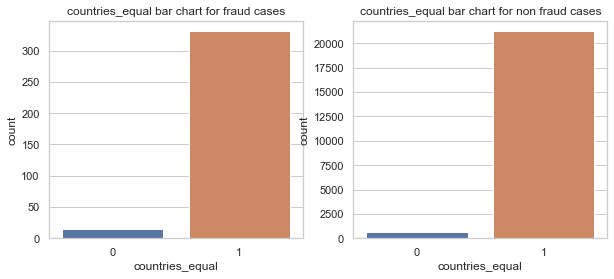

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))
sns.countplot(x="countries_equal", data=df_resample[df_resample.simple_journal == 1], ax=ax1)
ax1.set_title('countries_equal bar chart for fraud cases')

sns.countplot(x="countries_equal", data=df_resample[df_resample.simple_journal == 0], ax=ax2)
ax2.set_title('countries_equal bar chart for non fraud cases')
plt.show()

The feature is identical across the two class labels

## Time of Transaction: Day of Week and Hour of Day

In [24]:
df_resample["day_of_week"] = df_resample["creationdate"].dt.dayofweek
df_resample["hour"] = df_resample["creationdate"].dt.hour

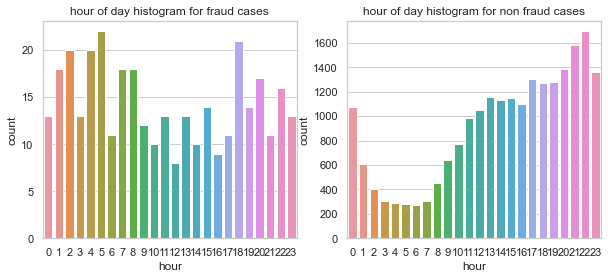

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))
sns.countplot(x="hour", data=df_resample[df_resample.simple_journal == 1], ax=ax1)
ax1.set_title('hour of day histogram for fraud cases')

sns.countplot(x="hour", data=df_resample[df_resample.simple_journal == 0], ax=ax2)
ax2.set_title('hour of day histogram for non fraud cases')
plt.show()

There is a clear difference in distribution between fraud and non-fraud. Fraudulent transactions tend to be distributed throughout the day, whereas non-fraudulent transactions gradually increase as the hour passes.

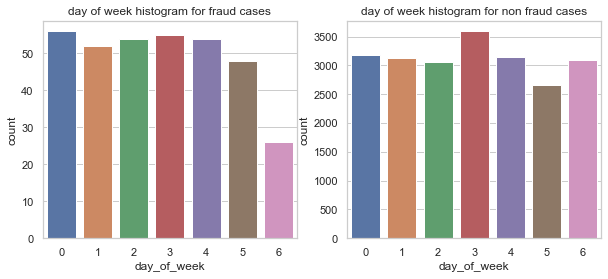

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))
sns.countplot(x="day_of_week", data=df_resample[df_resample.simple_journal == 1], ax=ax1)
ax1.set_title('day of week histogram for fraud cases')

sns.countplot(x="day_of_week", data=df_resample[df_resample.simple_journal == 0], ax=ax2)
ax2.set_title('day of week histogram for non fraud cases')

plt.show()

TODO: explain this

## Aggregate Features

TODO: describe new aggregrate features added

In [27]:
df_resample = aggregate_features(df_resample)

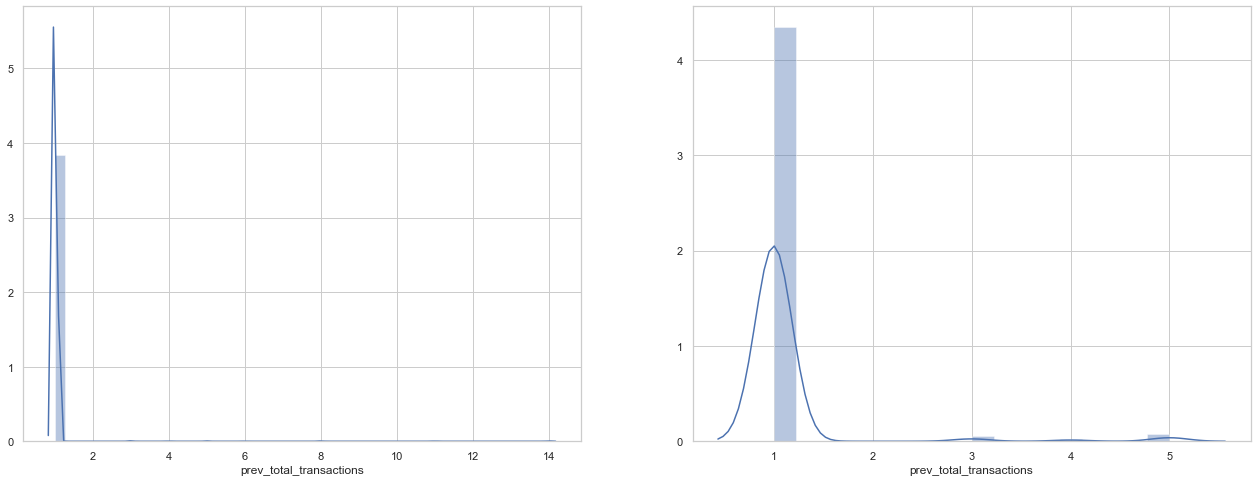

In [28]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==0]["prev_total_transactions"], ax=ax1)
sns.distplot(df_resample[df_resample.simple_journal==1]["prev_total_transactions"], ax=ax2)

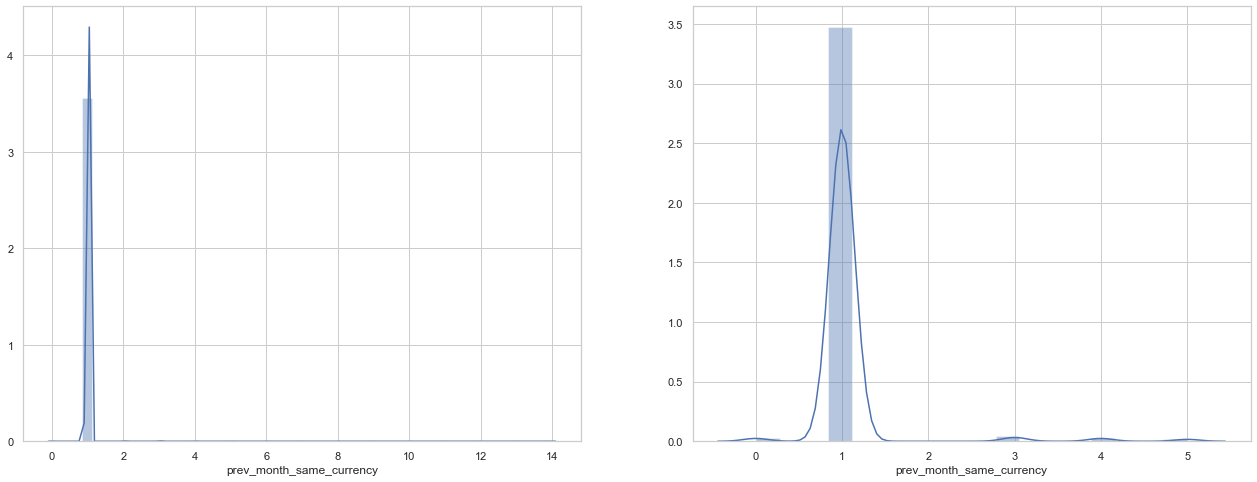

In [29]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==0]["prev_month_same_currency"], ax=ax1)
sns.distplot(df_resample[df_resample.simple_journal==1]["prev_month_same_currency"], ax=ax2)

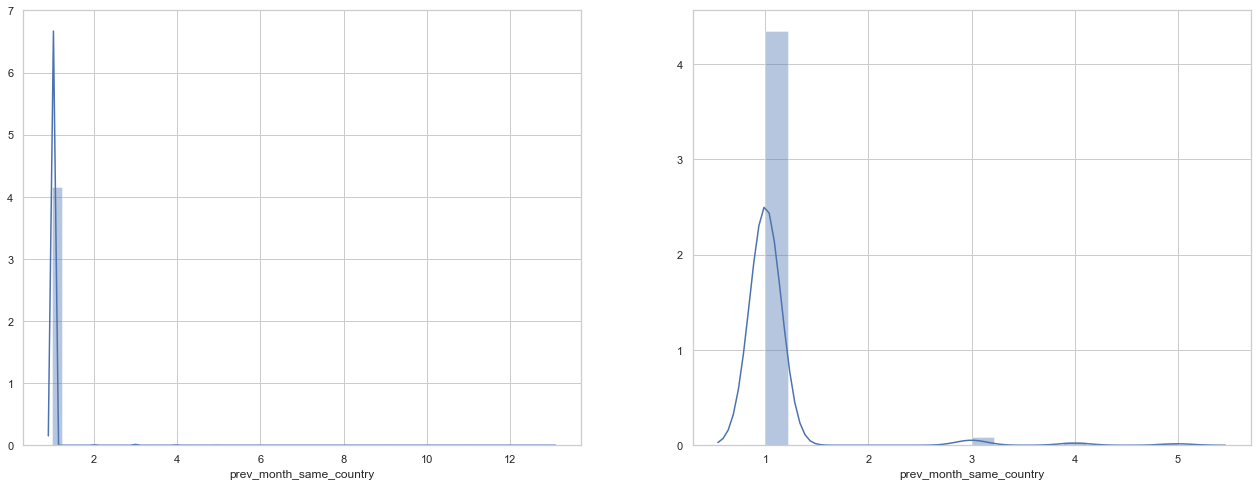

In [30]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==0]["prev_month_same_country"], ax=ax1)
sns.distplot(df_resample[df_resample.simple_journal==1]["prev_month_same_country"], ax=ax2)

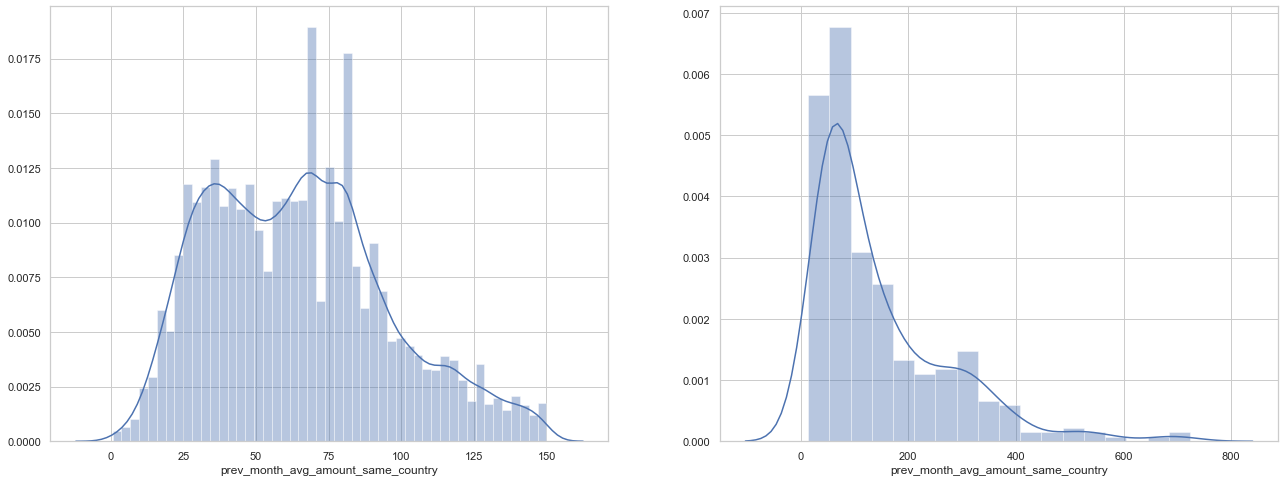

In [31]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==0]["prev_month_avg_amount_same_country"], ax=ax1)
sns.distplot(df_resample[df_resample.simple_journal==1]["prev_month_avg_amount_same_country"], ax=ax2)

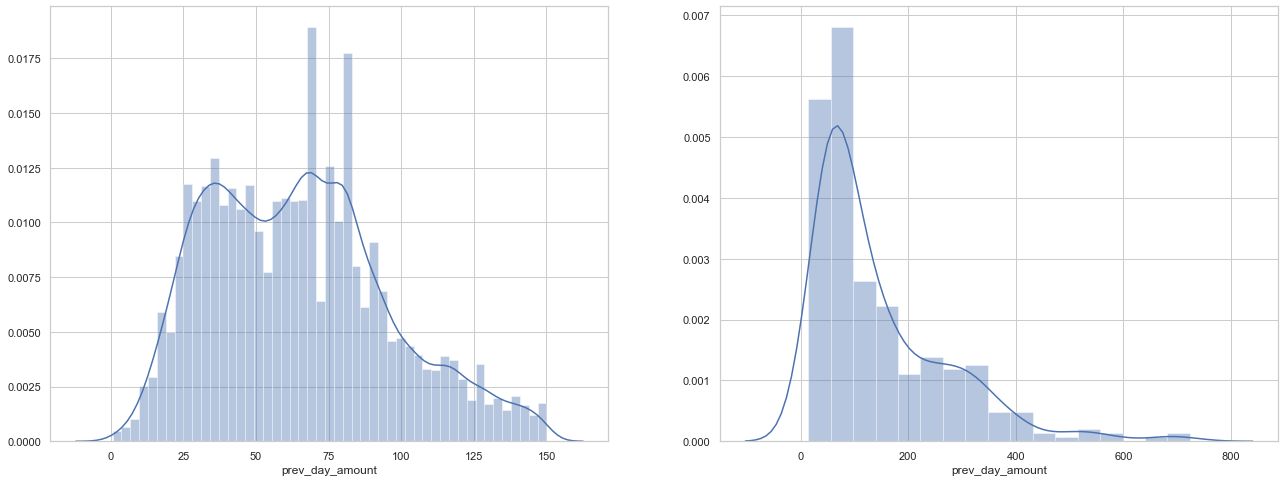

In [32]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==0]["prev_day_amount"], ax=ax1)
sns.distplot(df_resample[df_resample.simple_journal==1]["prev_day_amount"], ax=ax2)

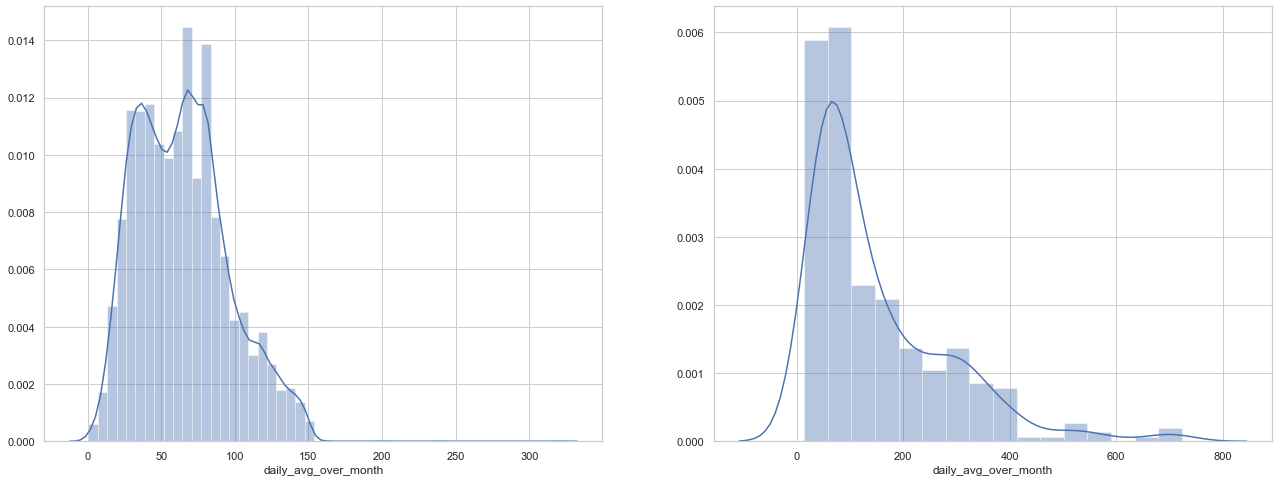

In [33]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==0]["daily_avg_over_month"], ax=ax1)
sns.distplot(df_resample[df_resample.simple_journal==1]["daily_avg_over_month"], ax=ax2)

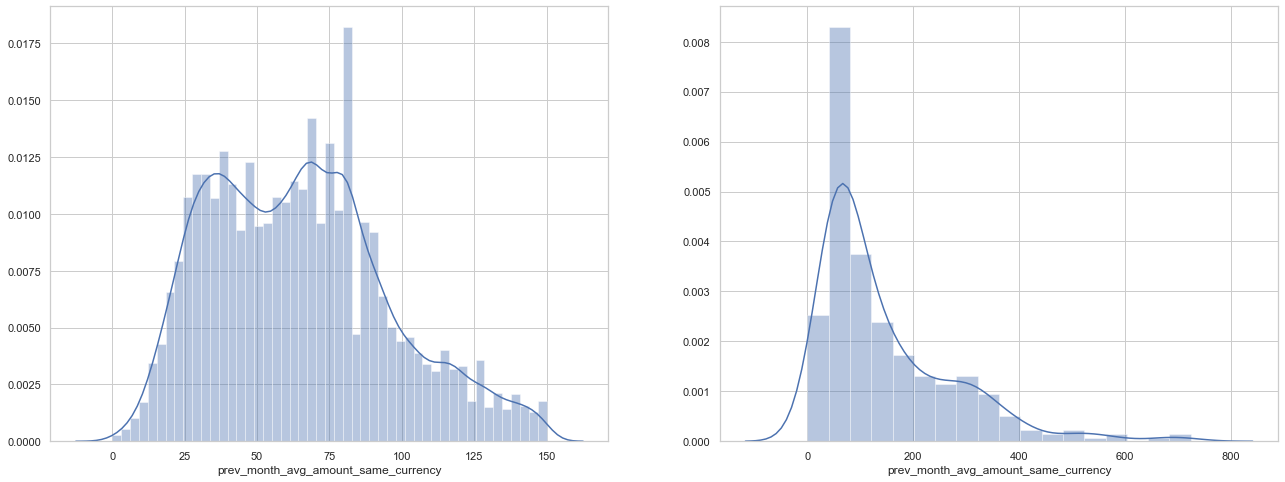

In [34]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==0]["prev_month_avg_amount_same_currency"], ax=ax1)
sns.distplot(df_resample[df_resample.simple_journal==1]["prev_month_avg_amount_same_currency"], ax=ax2)

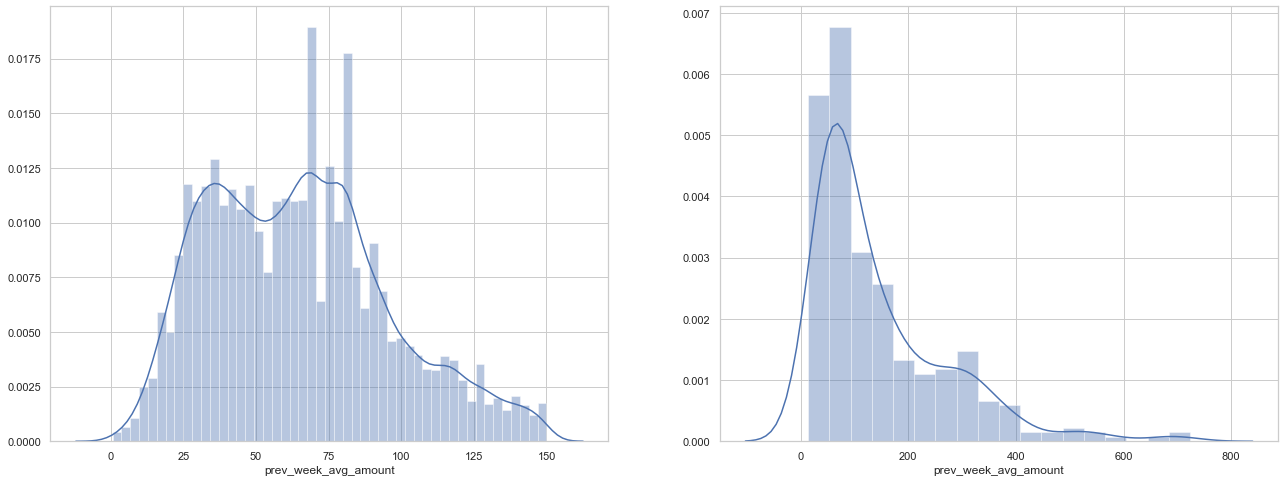

In [35]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==0]["prev_week_avg_amount"], ax=ax1)
sns.distplot(df_resample[df_resample.simple_journal==1]["prev_week_avg_amount"], ax=ax2)

In [36]:
features = ['accountcode_cc', 'amount_eur', 'bin', 'countries_equal', 'currencycode', 'cvcresponsecode', 'hour', 'issuercountrycode', 'shoppercountrycode', 'txvariantcode', 'prev_day_amount', 'prev_day_same_country', 'prev_month_avg_amount', 'prev_month_avg_amount_same_country', 'prev_month_avg_amount_same_currency', 'prev_month_same_country', 'prev_month_same_currency', 'prev_total_transactions', 'prev_week_avg_amount', 'daily_avg_over_month']
cat_col_idx = [0, 2, 3, 4, 5, 7, 8, 9]
X = df_resample[features].to_numpy().astype("float32")
y = df_resample["simple_journal"].to_numpy().astype("int32")

In [37]:
np.savez("./data/train_data.npz", X=X, y=y)

In [66]:
train_data = np.load("./data/train_data.npz")
X = train_data["X"]
y = train_data["y"]

In [67]:
y.sum()/y.shape[0]

0.015550347065717118

---
---

# VI. SMOTE and Train-Validation-Test Split

TODO: add explanation

In [68]:
features = ['accountcode_cc', 'bin', 'countries_equal', 'currencycode', 'cvcresponsecode', 'issuercountrycode', 'shoppercountrycode', 'txvariantcode', 'amount_eur', 'hour', 'prev_day_amount', 'prev_day_same_country', 'prev_month_avg_amount', 'prev_month_avg_amount_same_country', 'prev_month_avg_amount_same_currency', 'prev_month_same_country', 'prev_month_same_currency', 'prev_total_transactions', 'prev_week_avg_amount', 'daily_avg_over_month']
cat_col_idx = [0, 1, 2, 3, 4, 5, 6, 7]

In [58]:
sm = SMOTE(p=2, k=1, cat_cols=cat_col_idx)
sm.fit(X, y)
X, y = sm.transform()

In [59]:
y.sum()/y.shape[0]

0.020011665993628573

In [69]:
from sklearn.model_selection import StratifiedKFold

In [70]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
kfold.get_n_splits(X, y)

10

In [71]:
splits = list(kfold.split(X, y))

---
---

# VIII. Modelling

## A. Decision Trees

In [72]:
result_set = {
    "false_pos_rate": [],
    "true_pos_rate": [],
    "precision_curve": [],
    "recall_curve": [],
    "auc": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "tn": [],
    "tp": [],
    "fn": [],
    "fp": []
}
importances = np.zeros((X.shape[1]))
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model, result = models.DecisionTree(X_train, X_test, y_train, y_test)
    for k, v in result.items():
        result_set[k].append(v)
    importances += model.feature_importances_
importances /= 10.0
print(f"Fraudulent Cases Found: {sum(result_set['tp'])}, False Positives: {sum(result_set['fp'])}")

Fraudulent Cases Found: 159, False Positives: 219


## Feature Importances

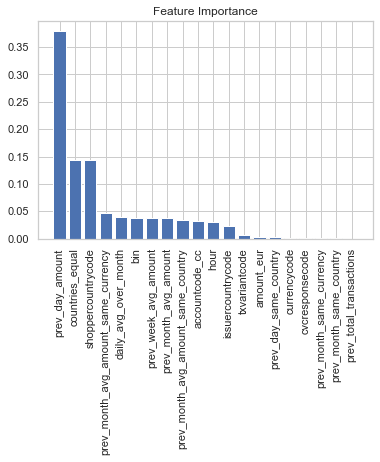

In [73]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

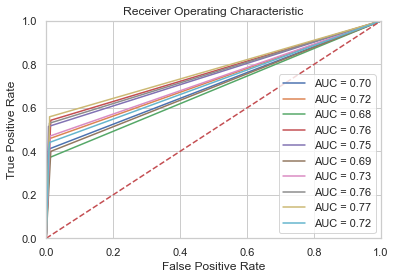

In [74]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
for fpr, tpr, auc in zip(result_set["false_pos_rate"], result_set["true_pos_rate"], result_set["auc"]):
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---
---